In [1]:
from fastai.vision.all import *

In [2]:
pd.options.display.max_columns = 100

In [3]:
datapath = Path("/home/code-base/scratch_space/rsna_data/")
train_df = pd.read_csv(datapath/'train.csv')
train_df.pe_present_on_image.mean()

0.053915069524414806

In [4]:
do_sample=False
if do_sample:
    sample_pids_dir = (datapath/'sample_pids')
    valid_pids = pd.read_pickle(sample_pids_dir/'valid_pids.pkl')
    train_pids = pd.read_pickle(sample_pids_dir/'train_pids.pkl')

    len(train_pids), len(valid_pids)

In [5]:
do_cv = True
FOLD = 0

if do_cv: 
    cv_pids_dir = (datapath/'cv_pids')
    if not cv_pids_dir.exists(): cv_pids_dir.mkdir()
    cv_df = train_df[['StudyInstanceUID', 'negative_exam_for_pe']].drop_duplicates().reset_index(drop=True)
    all_pids = cv_df['StudyInstanceUID'].values

    valid_pids = pd.read_pickle(datapath/f'cv_pids/pids_fold{FOLD}.pkl')
    train_pids = list(set(all_pids).difference(valid_pids))

In [6]:
len(train_pids), len(valid_pids), len(train_pids+valid_pids)

(5823, 1456, 7279)

In [7]:
metadata_path = datapath/'metadata'
train_metadata_paths = [o for o in metadata_path.ls() if o.stem in train_pids]
valid_metadata_paths = [o for o in metadata_path.ls() if o.stem in valid_pids]

In [8]:
len(train_metadata_paths), len(valid_metadata_paths)

(5823, 1456)

### Baseline valid performance

In [10]:
train_metadf = pd.concat([pd.read_csv(o) for o in train_metadata_paths]).reset_index(drop=True)
valid_metadf = pd.concat([pd.read_csv(o) for o in valid_metadata_paths]).reset_index(drop=True)

In [11]:
train_metadf.shape, valid_metadf.shape

((1431907, 68), (358687, 68))

In [12]:
train_metadf = train_metadf.merge(train_df, on=['StudyInstanceUID', 'SOPInstanceUID'])
valid_metadf = valid_metadf.merge(train_df, on=['StudyInstanceUID', 'SOPInstanceUID'])

In [13]:
train_metadf['pe_present_on_image'].mean(), valid_metadf['pe_present_on_image'].mean()

(0.05352169783393451, 0.055757592698709973)

In [14]:
p = valid_metadf['pe_present_on_image'].mean()

In [15]:
-(p*np.log(p)+(1-p)*np.log(1-p))

0.21513118096824402

In [16]:
targs = tensor(valid_metadf['pe_present_on_image'].values)
preds = torch.ones_like(targs)*p

In [17]:
F.binary_cross_entropy(preds,targs.float())

tensor(0.2151)

In [18]:
preds = torch.stack([torch.ones_like(targs)*(1-p), torch.ones_like(targs)*(p)],1)

In [19]:
preds

tensor([[0.9442, 0.0558],
        [0.9442, 0.0558],
        [0.9442, 0.0558],
        ...,
        [0.9442, 0.0558],
        [0.9442, 0.0558],
        [0.9442, 0.0558]])

In [20]:
baseline_ce = F.nll_loss(torch.log(preds), targs); baseline_ce

tensor(0.2151)

In [21]:
baseline_acc = 1 - p; baseline_acc

0.94424240730129

In [22]:
(1-p)/p

16.934777159472603

### All samples

In [23]:
labels_dict = dict(zip(train_df['SOPInstanceUID'], train_df['pe_present_on_image']))

In [24]:
len(labels_dict), len(train_df)

(1790594, 1790594)

In [25]:
imgdatapath = (datapath/'full_raw_512')

In [26]:
files = get_image_files(imgdatapath)

In [27]:
train_files = [o for o in files if o.parent.name in train_pids]
valid_files = [o for o in files if o.parent.name in valid_pids]

In [28]:
len(train_files), len(valid_files)

(1431907, 358687)

In [29]:
len(files)

1790594

### Smart Sample

We don't have to use all the slices as input data per patient. We can simply sample every nth slice for each patient so that we have good enough variability within that patient and use that data for CNN feature training. But always keep, if y = 1.

In [30]:
from fastai.medical.imaging import *

In [31]:
files_dict = defaultdict(list)
for o in files:
    files_dict[o.parent.name].append(o)

In [32]:
for k in files_dict:
    files_dict[k] = sorted(files_dict[k], key=lambda o: int(o.name.split('_')[0]))

(array([2.450e+02, 5.699e+03, 8.920e+02, 2.580e+02, 1.150e+02, 5.700e+01,
        7.000e+00, 2.000e+00, 0.000e+00, 4.000e+00]),
 array([  63.,  165.,  267.,  369.,  471.,  573.,  675.,  777.,  879.,
         981., 1083.]),
 <BarContainer object of 10 artists>)

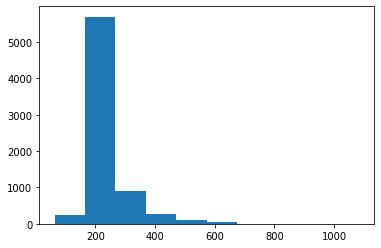

In [33]:
nslices = [len(files_dict[k]) for k in files_dict]
plt.hist(nslices)

In [34]:
def sample_patient_slices(pid, num_slice_samples):
    "Use a fixed number of samples per patient for training speed up"
    files = array(files_dict[pid])
    n = len(files)
    if n > num_slice_samples:
        labels = [labels_dict[o.stem.split("_")[1]] for o in files]
        pos_idxs = list(np.where(labels)[0])
        idxs = [np.clip(int(i), 0, n-1) for i in np.linspace(0, n, num_slice_samples)]
        idxs += pos_idxs
        idxs = sorted(set(idxs))
        return files[idxs]
    else: return files

In [35]:
train_sampled_files = parallel(partial(sample_patient_slices, num_slice_samples=200), train_pids)

In [36]:
train_files = []
for o in train_sampled_files: train_files += list(o)

In [37]:
valid_files = []
for o in valid_pids: valid_files += files_dict[o]

In [38]:
len(train_files), len(valid_files)

(1157707, 358687)

### Data

In [39]:
def aug_transforms(mult=1.0, do_flip=True, flip_vert=False, max_rotate=10., min_zoom=1., max_zoom=1.1,
                   max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=[], size=None,
                   mode='bilinear', pad_mode=PadMode.Reflection, align_corners=True, batch=False, min_scale=1.):
    "Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms."
    res,tkw = [],dict(size=size if min_scale==1. else None, mode=mode, pad_mode=pad_mode, batch=batch, align_corners=align_corners)
    max_rotate,max_lighting,max_warp = array([max_rotate,max_lighting,max_warp])*mult
    if do_flip: res.append(Dihedral(p=0.5, **tkw) if flip_vert else Flip(p=0.5, **tkw))
    if max_warp:   res.append(Warp(magnitude=max_warp, p=p_affine, **tkw))
    if max_rotate: res.append(Rotate(max_deg=max_rotate, p=p_affine, **tkw))
    if min_zoom<1 or max_zoom>1: res.append(Zoom(min_zoom=min_zoom, max_zoom=max_zoom, p=p_affine, **tkw))
    if max_lighting:
        res.append(Brightness(max_lighting=max_lighting, p=p_lighting, batch=batch))
        res.append(Contrast(max_lighting=max_lighting, p=p_lighting, batch=batch))
    if size: xtra_tfms += [RandomResizedCropGPU(size, min_scale=min_scale, ratio=(1,1))]
    return res + L(xtra_tfms)

In [40]:
wgtdict = {0:1, 1:10}

In [41]:
def get_label(o): 
    return labels_dict[o.stem.split("_")[1]]

In [42]:
class FlipUD(RandTransform):
    def __init__(self, p=0.5): super().__init__(p=p)
    def encodes(self, x:TensorImage): return x.flip(-2)

In [43]:
from time import time
def get_dls(train_files, valid_files, resize=256, size=224, bs=128):
    
    files = train_files + valid_files
    trn_wgts = [wgtdict[get_label(o)] for o in train_files]
    print(f"Collected idxs")

    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(resize, min_scale=0.9)], 
            [get_label, Categorize()]]
    dsets = Datasets(files, tfms=tfms,
                     splits=FuncSplitter(lambda o: True if o.parent.name in valid_pids else False)(files))
    print(f"Created dset")

    aug_tfms = aug_transforms(size=size, max_lighting=False, max_warp=False, flip_vert=False, min_scale=0.75,
                              xtra_tfms=[
                                      RandomErasing(p=0.25, sh=0.2, min_aspect=0.15), 
                                        ])    
    batch_tfms = [IntToFloatTensor] + aug_tfms
    dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms, dl_type=WeightedDL, dl_kwargs=[{"wgts":trn_wgts}, {}])
    print(f"DLs ready")
    return dls

In [44]:
opt_func = partial(ranger, **dict(sqrmom=0.99, mom=0.95, beta=0., eps=1e-4))

In [45]:
# Progressive Resizing
resize, size = (512, 480)
# resize, size = (256, 224)
dls = get_dls(train_files, valid_files, resize=resize, size=size, 
#               bs=int(64*(256/resize))
              bs=32
             )

Collected idxs
Created dset
DLs ready


In [46]:
resize, size

(512, 480)

In [47]:
loss_func = LabelSmoothingCrossEntropyFlat(eps=0.01)

In [48]:
# learn = cnn_learner(dls, xresnet34, opt_func=opt_func, 
#                     pretrained=False, loss_func=loss_func,
#                     metrics=[accuracy], cbs=[SaveModelCallback("accuracy", 
#                                                                fname=f"xresnet34-{resize}-PR-fold{FOLD}")])

In [49]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b3', num_classes=2)
learn = Learner(dls, model, opt_func=opt_func, 
                    pretrained=False, loss_func=loss_func,
                    metrics=[accuracy], cbs=[SaveModelCallback("accuracy", 
                                                               fname=f"effb3-{resize}-PR-fold{FOLD}")])

In [50]:
learn.dls.bs

32

In [51]:
loadpth = Path(f"effb3-256-PR-fold{FOLD}")
learn.load(loadpth)
print("loaded...")

loaded...


In [52]:
learn.to_fp16();

In [ ]:
learn.fit_flat_cos(3, 0.01)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
# learn.export(f"./models/xresnet34-{resize}-PR-fold{FOLD}-export.pkl");
learn.export(f"./models/effb3-{resize}-PR-fold{FOLD}-export.pkl");

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(20)

In [44]:
interp.print_classification_report()

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4355
           1       0.65      0.23      0.34       280

    accuracy                           0.95      4635
   macro avg       0.80      0.61      0.65      4635
weighted avg       0.93      0.95      0.93      4635



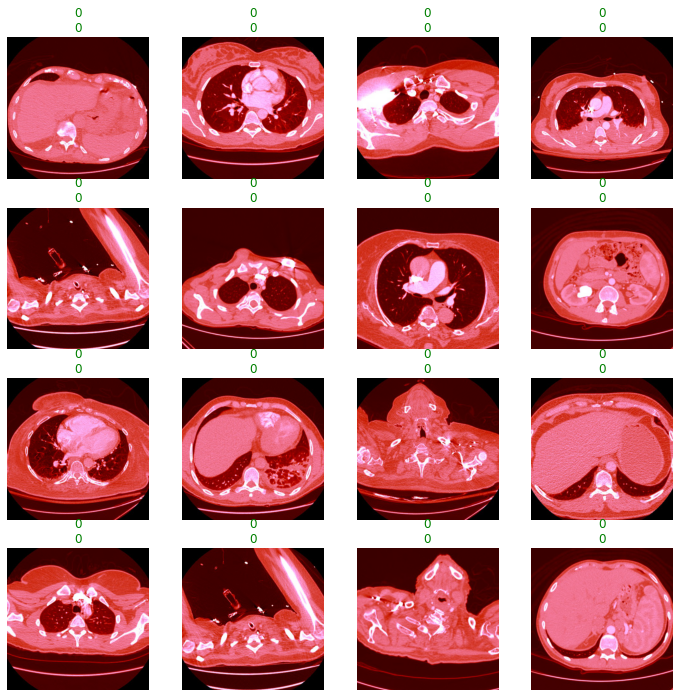

In [58]:
learn.show_results(max_n=16)

In [89]:
xb,yb=learn.dls.train.one_batch()
yb.float().mean()

TensorCategory(0.5000, device='cuda:0')

(array([3500.,  520.,  253.,  145.,   66.,   53.,   38.,   26.,   18.,
          16.]),
 array([0.02010024, 0.10072639, 0.18135254, 0.2619787 , 0.34260485,
        0.423231  , 0.50385714, 0.5844833 , 0.66510946, 0.74573565,
        0.8263618 ], dtype=float32),
 <BarContainer object of 10 artists>)

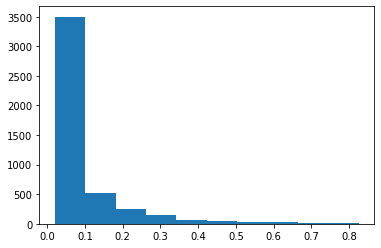

In [94]:
plt.hist(interp.preds[:,1].numpy())

### Generate OOF Preds & Embeddings